## Projet Repaint : Inpainting using denoising diffusion probabilistic model

Ezekiel REMBANGOUET \
Racha ROCHDI \
Jean-Pierre MANSOUR \
Paul PASQUET


Le processus d'Image Inpainting, ou complétion d'image consiste à compléter une région manquante sur une image. Pour ce faire, il est possible d'utiliser des modèles génératifs tels que des modèles Autorégressif ou GAN. Une autre alternative possible est le modèle Denoising Diffusion (DDPM). Ce dernier peut même se montrer plus performant que le GAN. Le but de ce rapport est de présenter le modèle Denoising Diffusion.

### 1. Le modèle direct

Dans ce projet, nous utilisons le DDPM comme un modèle génératif. Comme pour d'autres modèles génératifs, le DDPM apprend à partir d'un ensemble d'entraînement. Pour ce faire, le processus d'inférence part d'un vecteur bruité $x_T$ qu'il débruite jusqu'à obtenir une image $x_0$ la plus nette possible. Ensuite, pendant l'entraînement le DDPM définit un processus de diffusion transformant l'image $x_0$ en un bruit blanc Gaussien $x_T$ de loi centrée réduite en $T$ pas de temps. Chaque pas est donné par
\begin{equation}
    q(x_t|x_{t-1}) = \mathcal{N}(x_t;\sqrt{1 - \beta_t}x_{t-1},\beta_{t}I)
\end{equation}
On remarque dans la formule ci-dessus que chaque pas de temps s'obtient uniquement en fonction du pas précédent, le processus est donc Markovien. Cependant, on remarque aussi qu'un bruit est rajouté à chaque pas de temps, ce qui a pour inconvénient de rendre l'entraînement très coûteux. Pour rendre l'entraînement plus rapide, on peut alors poser $\alpha_t = 1 - \beta_t$ pour chaque pas de temps $t$. L'expression ci-dessus devient donc
\begin{equation}
    q(x_t|x_{t-1}) = \mathcal{N}(x_t;\sqrt{\alpha_t}x_{t-1},(1-\alpha_{t})I)
\end{equation}
En utilisant le fait que les bruits ajoutés à chaque pas sont indépendants, on peut montrer que la variance du bruit total vaut $\widehat{\alpha}_t = \Pi_{s=1}^{t}(1 - \beta_s)$. Ceci permet de déduire l'expression suivante de l'expression ci-dessus :
\begin{align}
    q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\widehat{\alpha}_t}x_{t-1},(1-\widehat{\alpha_{t}})I)
\end{align}
Cette expression se montrera aussi utile pour travailler sur le processus inverse.

### 2. Le processus inverse

Le DDPM est également entraîné pour inverser le processus. Le processus inverse est modélisé par un réseau de neurones prédisant les paramètres $\mu_{\theta}(x_t,t)$ et $\Sigma_{\theta}(x_t,t)$ dans la distribution gaussienne
\begin{align}
    p_{\theta}(x_t|x_{t-1}) = \mathcal{N}(x_{t-1};\mu_{\theta}(x_t,t),\Sigma_{\theta}(x_t,t)))
\end{align}
qui modélise le bruit $\epsilon_{\theta}(x_t,t)$ à prédire. On peut montrer que la moyenne à prédire s'exprime par
\begin{align}
    \mu_{\theta}(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1 - \widehat{\alpha}_t}}\epsilon_{\theta}(x_t,t)\right)
\end{align}



### 3. La méthode

### 3.1 Conditionnement de la région connue

Le but de l'inpainting est de prédire les pixels manquants sur une région masquée d'une image. On note $x$ l'image avec une région masquée. On note $m \odot x$ la région masquée de l'image et $(1 - m)\odot x$ la région visible. En combinant le processus direct et le processus inverse on a les expressions suivantes :
\begin{align}
  x_{t-1}^{known} \sim \mathcal{N}(\sqrt{\widehat{\alpha}_t}x_0,(1 - \widehat{\alpha}_t)I)
\end{align}
\begin{align}
  x_{t-1}^{unknown} \sim \mathcal{N}(\mu_{\theta}(x_t,t),\Sigma_{\theta}(x_t,t))
\end{align}

On peut alors prédire $x_{t-1}$ comme suit :
\begin{align}
  x_{t-1} = m \odot x_{t-1}^{known} + (1 - m) \odot x_{t-1}^{unknown}
\end{align}

Dans ce cas, $x_{t-1}^{known}$ s'obtient en utilisant les pixels connus dans l'image de départ $m \odot x_0$ et $x_{t-1}^{unknown}$ s'obtient à partir du modèle inverse.


### 3.2 Le rôle du « rééchantillonnage » (Resampling)

Le cœur de l’innovation RePaint est d’alterner des petits retours en arrière et des réinjections de bruit, plutôt que de simplement descendre  $(x_t→x_t−1→⋯→x_0)$  en une seule fois.

Concrètement :

Pourquoi du rééchantillonnage ?

Sans rééchantillonnage, la zone inconnue peut être plausible à court terme, mais elle n’est pas toujours bien « harmonisée » avec les pixels connus à chaque étape.

RePaint propose de revenir légèrement en avant dans la chaîne de bruit (rajouter un peu de bruit) et de redescendre à nouveau, ce qui permet au modèle de mieux ajuster la zone générée en tenant compte des pixels connus réinjectés.  


2- Mécanisme

À chaque itération, on fait plusieurs sous-passes (notées $u=1,…,U$).
À la fin de certaines sous-passes, on « ralentit » ou on réintroduit un peu de bruit (partiel) dans l’image, puis on redescend.
Cela se traduit par des aller-retours dans le temps de diffusion, de sorte qu’à chaque fois, la zone inconnue soit réapprise en fonction de la zone connue.  


3-Avantage

Cette technique augmente le budget de calcul (plus d’échantillonnages), mais elle conduit à des résultats plus cohérents et plus sémantiquement convaincants.
Contrairement à la simple approche consistant à « ralentir » la diffusion (ajuster $𝛽_𝑡$), la méthode RePaint utilise vraiment ce budget supplémentaire pour améliorer l’harmonisation entre zone connue et zone générée.


## 4. Principaux avantages et points saillants  

1 Pas de réentraînement spécifique aux masques

Comme le modèle est un DDPM inconditionnel déjà entraîné, on peut appliquer RePaint à n’importe quel type de masque (masque mince, large, masques complexes, etc.).
Les autres méthodes, souvent basées sur des GAN entraînés sur certains masques ou certains types de trous, peuvent avoir plus de mal à généraliser.

2-Grande diversité et flexibilité

Chaque étape de rétro-diffusion étant stochastique (bruit gaussien), RePaint peut produire plusieurs complétions possibles pour la même zone masquée, toutes restant cohérentes avec la distribution des données d’origine.


3-Qualité visuelle et sémantique

Les tests sur des bases comme CelebA-HQ et ImageNet montrent que RePaint obtient des scores élevés, notamment grâce à la possibilité d’harmoniser sans cesse la zone reconstruite avec les pixels restants.


4-Limites

Étant donné qu’il est inconditionnel, le modèle peut parfois s’éloigner de la vérité terrain (ground truth) si l’image d’origine a des particularités peu fréquentes dans les données d’entraînement.
La métrique LPIPS peut pénaliser ces divergences si le résultat, malgré sa qualité visuelle, est trop différent des pixels de référence.

In [1]:
!git clone https://github.com/andreas128/RePaint.git

Cloning into 'RePaint'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 85 (delta 42), reused 26 (delta 26), pack-reused 35 (from 1)
Receiving objects: 100% (85/85), 49.88 KiB | 1.92 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
pip install numpy torch blobfile tqdm pyYaml pillow    # e.g. torch 1.7.1+cu110.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 91.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [3]:
!pip install gdown --upgrade

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ifigotin/imagenetmini-1000")

print("Path to dataset files:", path)

100%|██████████| 3.92G/3.92G [00:21<00:00, 192MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ifigotin/imagenetmini-1000/versions/1


In [6]:
import shutil

# Your dataset path (from KaggleHub in Colab)
dataset_path = "/root/.cache/kagglehub/datasets/ifigotin/imagenetmini-1000/versions/1/imagenet-mini/val/"

# Destination path (where RePaint expects images)
destination_path = "./data/datasets/gts/inet256_temp/"

# Ensure the destination folder exists
import os
os.makedirs(destination_path, exist_ok=True)

# Copy images (adjusted paths)
shutil.copy(dataset_path + "n03372029/ILSVRC2012_val_00028591.JPEG", destination_path + "ILSVRC2012_val_00028591.JPEG")
shutil.copy(dataset_path + "n01797886/ILSVRC2012_val_00021417.JPEG", destination_path + "ILSVRC2012_val_00021417.JPEG")
shutil.copy(dataset_path + "n02106550/ILSVRC2012_val_00022664.JPEG", destination_path + "ILSVRC2012_val_00022664.JPEG")
shutil.copy(dataset_path + "n02437312/ILSVRC2012_val_00009825.JPEG", destination_path + "ILSVRC2012_val_00009825.JPEG")
shutil.copy(dataset_path + "n02701002/ILSVRC2012_val_00025159.JPEG", destination_path + "ILSVRC2012_val_00025159.JPEG")
shutil.copy(dataset_path + "n02917067/ILSVRC2012_val_00020919.JPEG", destination_path + "ILSVRC2012_val_00020919.JPEG")
shutil.copy(dataset_path + "n02992211/ILSVRC2012_val_00013202.JPEG", destination_path + "ILSVRC2012_val_00013202.JPEG")
shutil.copy(dataset_path + "n03042490/ILSVRC2012_val_00025402.JPEG", destination_path + "ILSVRC2012_val_00025402.JPEG")
shutil.copy(dataset_path + "n03187595/ILSVRC2012_val_00020238.JPEG", destination_path + "ILSVRC2012_val_00020238.JPEG")
shutil.copy(dataset_path + "n03457902/ILSVRC2012_val_00035478.JPEG", destination_path + "ILSVRC2012_val_00035478.JPEG")

print("✅ All images successfully copied!")

✅ All images successfully copied!


In [7]:
import os
from PIL import Image


img_arr = []

directory = os.fsencode("./data/datasets/gts/inet256_temp/")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    img = Image.open(os.path.join("./data/datasets/gts/inet256_temp/", filename), 'r')
    img_arr.append(img)


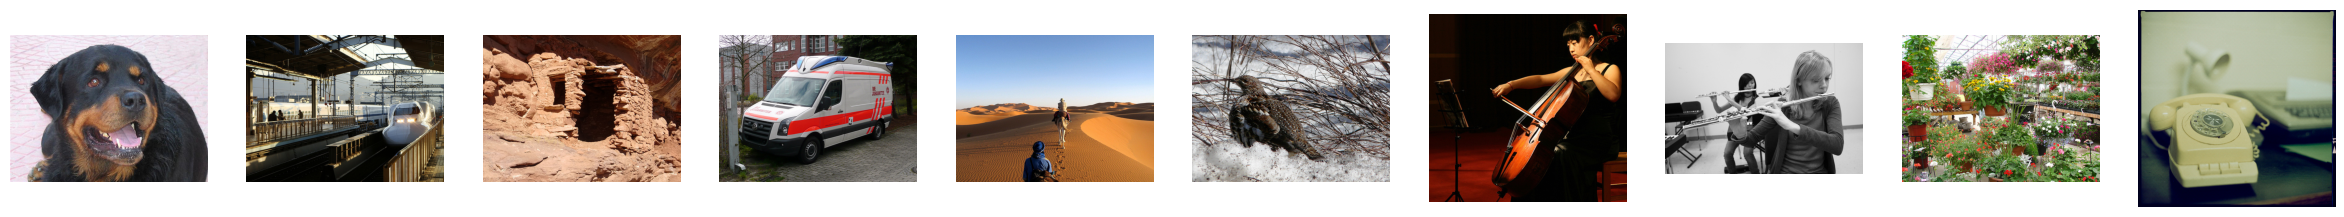

In [8]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showInline(arr):
    fig = figure(figsize=(30, 100))
    for i in range(len(img_arr)):
        a = fig.add_subplot(1, len(arr), i+1)
        imshow(arr[i], cmap='Greys_r')
        axis('off')

showInline(img_arr)

In [9]:
resized_arr = []

for i in range(len(img_arr)):
    width, height = img_arr[i].size
    ref = min(width, height)
    if ref == height:
        new_width = height

        left = (width-new_width) / 2
        top = 0
        right = left+new_width
        bottom = height
    else:
        new_height = width

        left = 0
        top = (height-new_height) / 2
        right = width
        bottom = top+new_height

    resized_arr.append(img_arr[i].crop((left, top, right, bottom)))

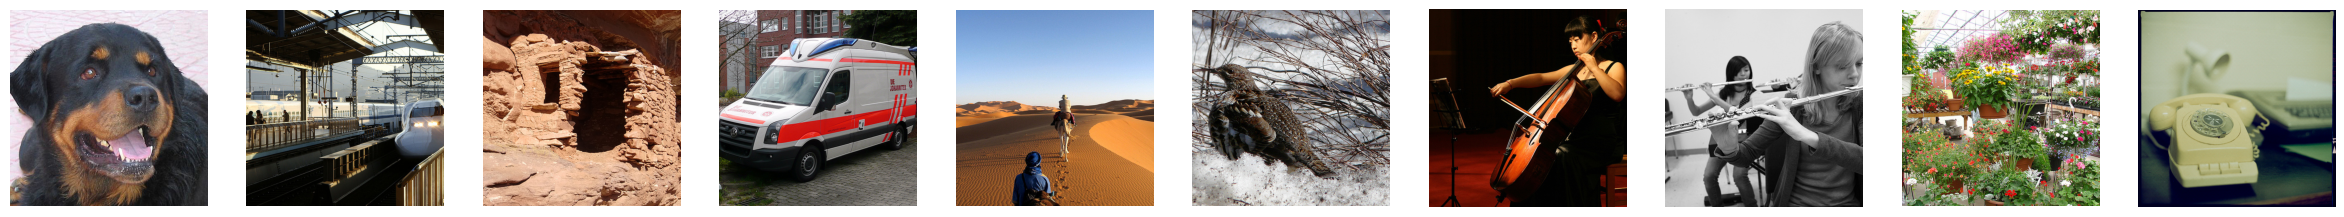

In [10]:
showInline(resized_arr)

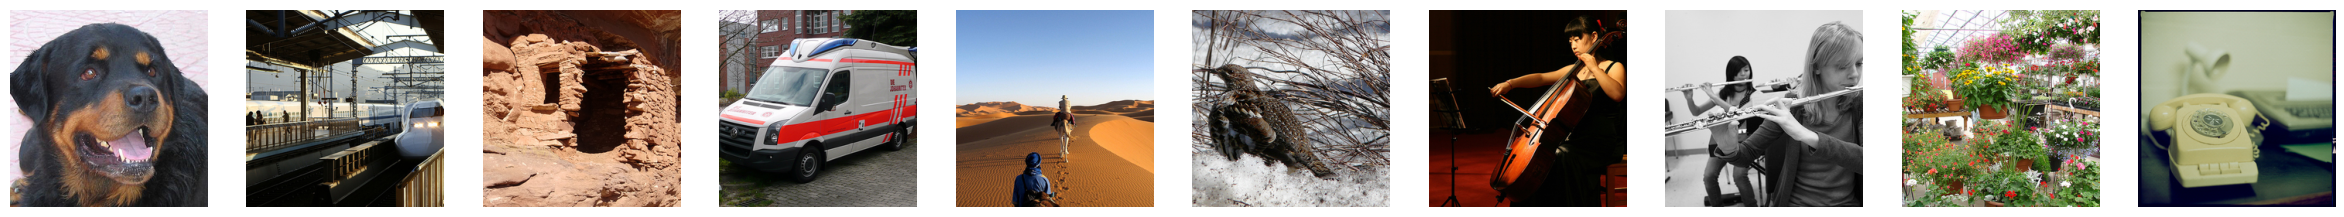

In [11]:
cropped_arr = []

for i in range(len(resized_arr)):
    cropped_arr.append(resized_arr[i].resize((256, 256), Image.Resampling.LANCZOS))

showInline(cropped_arr)

In [20]:
import yaml
import os

# Correct the path construction, remove extra './RePaint'
yaml_file_path = os.path.join("./RePaint", "confs", "test_inet256_thin.yml")

with open(yaml_file_path) as f:
    doc = yaml.safe_load(f)

doc["data"]["eval"]["lama_inet256_thin_n100_test"]["batch"] = 1
doc["data"]["eval"]["lama_inet256_thin_n100_test"]["max_len"] = 10
doc["data"]["eval"]["lama_inet256_thin_n100_test"]["mask_path"] = "./data/datasets/gt_keep_masks/my_thin"
doc["classifier_scale"] = 0

with open(yaml_file_path, "w") as f:
    yaml.dump(doc, f, default_flow_style=False)

In [34]:
os.makedirs("./data/datasets/gts/inet256", exist_ok=True)
os.makedirs("./data/datasets/gts/p256", exist_ok=True)

print("✅ Dossiers 'inet256' et 'p256' créés.")


✅ Dossiers 'inet256' et 'p256' créés.


In [35]:
import os
dataset_path = "/root/.cache/kagglehub/datasets/ifigotin/imagenetmini-1000/versions/1/imagenet-mini/val/"
if os.path.exists(dataset_path):
    print("📂 Contenu de ImageNet Mini:", os.listdir(dataset_path)[:10])  # Affiche 10 fichiers
else:
    print("🚨 ImageNet Mini n'est pas trouvé.")


📂 Contenu de ImageNet Mini: ['n03602883', 'n02963159', 'n01776313', 'n02526121', 'n02105251', 'n01582220', 'n01728572', 'n03982430', 'n02100877', 'n02398521']


In [103]:
import os
import shutil

dataset_path = "/root/.cache/kagglehub/datasets/ifigotin/imagenetmini-1000/versions/1/imagenet-mini/val/"
destination_path = "./data/datasets/gts/inet256/"

# Vérifie que le dossier ImageNet Mini existe
if os.path.exists(dataset_path):
    os.makedirs(destination_path, exist_ok=True)

    copied_files = 0
    for category in os.listdir(dataset_path):  # Catégories ex: 'n04229816'
        category_path = os.path.join(dataset_path, category)

        if os.path.isdir(category_path):  # Vérifie que c'est un dossier
            for file in os.listdir(category_path)[:5]:  # Copie 5 images par catégorie
                src_file = os.path.join(category_path, file)
                dest_file = os.path.join(destination_path, file)

                if os.path.isfile(src_file):  # Vérifie que c'est une image
                    shutil.copy(src_file, dest_file)
                    copied_files += 1

    print(f"✅ {copied_files} images copiées dans {destination_path}")
else:
    print("🚨 Le dataset ImageNet Mini est introuvable.")


✅ 3704 images copiées dans ./data/datasets/gts/inet256/


In [48]:
print("📂 Contenu de 'inet256':", os.listdir("./data/datasets/gts/inet256")[:10])


📂 Contenu de 'inet256': ['ILSVRC2012_val_00035038.JPEG', 'ILSVRC2012_val_00034667.JPEG', 'ILSVRC2012_val_00016981.JPEG', 'ILSVRC2012_val_00025337.JPEG', 'ILSVRC2012_val_00039019.JPEG', 'ILSVRC2012_val_00011420.JPEG', 'ILSVRC2012_val_00043381.JPEG', 'ILSVRC2012_val_00010778.JPEG', 'ILSVRC2012_val_00017449.JPEG', 'ILSVRC2012_val_00017931.JPEG']


In [51]:
import os

pretrained_dir = "./data/pretrained"
os.makedirs(pretrained_dir, exist_ok=True)

print(f"📂 Dossier '{pretrained_dir}' vérifié et créé si nécessaire.")


📂 Dossier './data/pretrained' vérifié et créé si nécessaire.


In [52]:
os.makedirs("./data/datasets/gt_keep_masks/thin", exist_ok=True)
print("✅ Dossier 'gt_keep_masks/thin' créé.")


✅ Dossier 'gt_keep_masks/thin' créé.


In [53]:
print("📂 Contenu de 'gt_keep_masks':", os.listdir("./data/datasets/gt_keep_masks"))
print("📂 Contenu de 'thin':", os.listdir("./data/datasets/gt_keep_masks/thin"))


📂 Contenu de 'gt_keep_masks': ['thin']
📂 Contenu de 'thin': ['000066.png', '000019.png', '000039.png', '000034.png', '000017.png', '000082.png', '000049.png', '000047.png', '000077.png', '000012.png', '000069.png', '000099.png', '000016.png', '000029.png', '000018.png', '000074.png', '000060.png', '000028.png', '000071.png', '000097.png', '000020.png', '000065.png', '000059.png', '000090.png', '000001.png', '000043.png', '000061.png', '000079.png', '000091.png', '000086.png', '000027.png', '000003.png', '000068.png', '000096.png', '000087.png', '000042.png', '000080.png', '000032.png', '000067.png', '000084.png', '000033.png', '000044.png', '000006.png', '000053.png', '000054.png', '000088.png', '000093.png', '000094.png', '000055.png', '000021.png', '000072.png', '000064.png', '000010.png', '000050.png', '000005.png', '000000.png', '000015.png', '000022.png', '000024.png', '000083.png', '000037.png', '000025.png', '000045.png', '000008.png', '000095.png', '000002.png', '000014.png', '

In [54]:
!wget -O ./data/pretrained/256x256_diffusion.pt https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion.pt

--2025-02-15 11:14:41--  https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion.pt
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 57.150.97.129
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|57.150.97.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2215479544 (2.1G) [application/octet-stream]
Saving to: ‘./data/pretrained/256x256_diffusion.pt’

./data/pretrained/2 100%[===================>]   2.06G  30.2MB/s    in 81s     

2025-02-15 11:16:03 (26.0 MB/s) - ‘./data/pretrained/256x256_diffusion.pt’ saved [2215479544/2215479544]



In [30]:
!wget -O ./data/pretrained/256x256_classifier.pt https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_classifier.pt


--2025-02-15 11:01:49--  https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_classifier.pt
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 57.150.97.129
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|57.150.97.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216496432 (206M) [application/octet-stream]
Saving to: ‘./data/pretrained/256x256_classifier.pt’

./data/pretrained/2 100%[===================>] 206.47M  27.9MB/s    in 7.0s    

2025-02-15 11:01:56 (29.5 MB/s) - ‘./data/pretrained/256x256_classifier.pt’ saved [216496432/216496432]



In [31]:
!gdown https://drive.google.com/uc?id=1Q_dxuyI41AAmSv9ti3780BwaJQqwvwMv -O data.zip


Downloading...
From: https://drive.google.com/uc?id=1Q_dxuyI41AAmSv9ti3780BwaJQqwvwMv
To: /content/RePaint/data.zip
100% 1.61M/1.61M [00:00<00:00, 170MB/s]


In [32]:
!ls -R ./data


./data:
datasets  pretrained

./data/datasets:
gt_keep_masks

./data/datasets/gt_keep_masks:
thin

./data/datasets/gt_keep_masks/thin:

./data/pretrained:
256x256_classifier.pt  256x256_diffusion.pt


In [102]:
import os
print("Images :", len(os.listdir("./data/datasets/gts/inet256")))
print("Masques :", len(os.listdir("./data/datasets/gt_keep_masks/thin")))


Images : 0
Masques : 0


In [77]:
!ls -l ./data/datasets/
!ls -l ./data/datasets/gt_keep_masks/


total 8
drwxr-xr-x 4 root root 4096 Feb 15 11:22 gt_keep_masks
drwxr-xr-x 5 root root 4096 Feb 15 11:17 gts
total 8
drwxr-xr-x 2 root root 4096 Feb 15 11:22 thin
drwxr-xr-x 2 root root 4096 Feb 15 11:22 thin_backup


In [104]:
!unzip -o data.zip -d ./data/


Archive:  data.zip
   creating: ./data/data/
   creating: ./data/data/datasets/
   creating: ./data/data/datasets/gts/
   creating: ./data/data/datasets/gts/face/
  inflating: ./data/data/datasets/gts/face/000007.png  
  inflating: ./data/data/datasets/gts/face/000006.png  
  inflating: ./data/data/datasets/gts/face/000004.png  
  inflating: ./data/data/datasets/gts/face/000005.png  
  inflating: ./data/data/datasets/gts/face/000001.png  
  inflating: ./data/data/datasets/gts/face/000000.png  
  inflating: ./data/data/datasets/gts/face/000002.png  
  inflating: ./data/data/datasets/gts/face/000003.png  
   creating: ./data/data/datasets/gt_keep_masks/
   creating: ./data/data/datasets/gt_keep_masks/face/
  inflating: ./data/data/datasets/gt_keep_masks/face/000007.png  
  inflating: ./data/data/datasets/gt_keep_masks/face/000006.png  
  inflating: ./data/data/datasets/gt_keep_masks/face/000004.png  
  inflating: ./data/data/datasets/gt_keep_masks/face/000005.png  
  inflating: ./data/da

In [105]:
mv ./data/data/datasets/gt_keep_masks/thin/* ./data/datasets/gt_keep_masks/thin/

In [80]:
rm -r ./data/data/


In [106]:
ls -l ./data/datasets/gt_keep_masks/thin/


total 724
-rw-r----- 1 root root 6257 Jul 18  2022 000000.png
-rw-r----- 1 root root 5613 Jul 18  2022 000001.png
-rw-r----- 1 root root 2121 Jul 18  2022 000002.png
-rw-r----- 1 root root 2018 Jul 18  2022 000003.png
-rw-r----- 1 root root 5571 Jul 18  2022 000004.png
-rw-r----- 1 root root 5423 Jul 18  2022 000005.png
-rw-r----- 1 root root 7059 Jul 18  2022 000006.png
-rw-r----- 1 root root 4668 Jul 18  2022 000007.png
-rw-r----- 1 root root 5539 Jul 18  2022 000008.png
-rw-r----- 1 root root 5307 Jul 18  2022 000009.png
-rw-r----- 1 root root 6657 Jul 18  2022 000010.png
-rw-r----- 1 root root 6892 Jul 18  2022 000011.png
-rw-r----- 1 root root 6519 Jul 18  2022 000012.png
-rw-r----- 1 root root 5741 Jul 18  2022 000013.png
-rw-r----- 1 root root 5752 Jul 18  2022 000014.png
-rw-r----- 1 root root 5376 Jul 18  2022 000015.png
-rw-r----- 1 root root 5300 Jul 18  2022 000016.png
-rw-r----- 1 root root 5638 Jul 18  2022 000017.png
-rw-r----- 1 root root 2877 Jul 18  2022 000018.png
-r

In [107]:
mkdir -p ./data/datasets/gts/inet256_backup/


In [108]:
ls ./data/datasets/gts/inet256/ | tail -n +102 | xargs -I {} mv ./data/datasets/gts/inet256/{} ./data/datasets/gts/inet256_backup/


In [109]:
import os
print("Images:", len(os.listdir("./data/datasets/gts/inet256")))
print("Masks:", len(os.listdir("./data/datasets/gt_keep_masks/thin")))


Images: 101
Masks: 100


In [125]:
!ls -1 ./data/datasets/gts/inet256/ | tail -n +21 | xargs -I {} mv ./data/datasets/gts/inet256/{} ./data/datasets/gts/inet256_backup/
!ls -1 ./data/datasets/gt_keep_masks/thin/ | tail -n +21 | xargs -I {} mv ./data/datasets/gt_keep_masks/thin/{} ./data/datasets/gt_keep_masks/thin_backup/

# Vérification
!echo "Images restantes:" $(ls -1 ./data/datasets/gts/inet256/ | wc -l)
!echo "Masques restants:" $(ls -1 ./data/datasets/gt_keep_masks/thin/ | wc -l)

Images restantes: 20
Masques restants: 20


In [86]:
!sed -i "s/num_samples: [0-9]\+/num_samples: 20/; s/timestep_respacing: '[0-9]\+'/timestep_respacing: '100'/" confs/test_inet256_thin.yml


In [87]:
!grep "num_samples" confs/test_inet256_thin.yml


num_samples: 20


In [90]:
!sed -i "s/timestep_respacing: '1000'/timestep_respacing: '100'/" confs/test_inet256_thin.yml


In [91]:
!grep "timestep_respacing" confs/test_inet256_thin.yml


timestep_respacing: '100'


In [92]:
!sed -i "s/timestep_respacing: '100'/timestep_respacing: '250'/" confs/test_inet256_thin.yml


In [ ]:
!sed -i 's/batch_size: [0-9]\+/batch_size: 4/' confs/test_inet256_thin.yml
!grep "batch_size" confs/test_inet256_thin.yml


      batch_size: 4


In [93]:
!sed -i 's/max_len: [0-9]\+/max_len: 20/' confs/test_inet256_thin.yml
!grep "max_len" confs/test_inet256_thin.yml


      max_len: 20


In [112]:
# Afficher les fichiers image
!ls -1 ./data/datasets/gts/inet256/

# Afficher les fichiers masque
!ls -1 ./data/datasets/gt_keep_masks/thin/


ILSVRC2012_val_00000013.JPEG
ILSVRC2012_val_00000029.JPEG
ILSVRC2012_val_00000063.JPEG
ILSVRC2012_val_00000072.JPEG
ILSVRC2012_val_00000073.JPEG
ILSVRC2012_val_00000094.JPEG
ILSVRC2012_val_00000099.JPEG
ILSVRC2012_val_00000108.JPEG
ILSVRC2012_val_00000110.JPEG
ILSVRC2012_val_00000126.JPEG
ILSVRC2012_val_00000162.JPEG
ILSVRC2012_val_00000171.JPEG
ILSVRC2012_val_00000178.JPEG
ILSVRC2012_val_00000192.JPEG
ILSVRC2012_val_00000202.JPEG
ILSVRC2012_val_00000216.JPEG
ILSVRC2012_val_00000229.JPEG
ILSVRC2012_val_00000232.JPEG
ILSVRC2012_val_00000282.JPEG
ILSVRC2012_val_00000303.JPEG
000000.png
000001.png
000002.png
000003.png
000004.png
000005.png
000006.png
000007.png
000008.png
000009.png
000010.png
000011.png
000012.png
000013.png
000014.png
000015.png
000016.png
000017.png
000018.png
000019.png


In [126]:
!python test.py --conf_path confs/test_inet256_thin.yml


Start test_inet256_thin
/content/RePaint/guided_diffusion/dist_util.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(io.BytesIO(data), **kwargs)
sampling.

In [ ]:
!ls -l ./log/test_inet256_thin/inpainted/
!ls -l ./log/test_inet256_thin/gt_masked/
!ls -l ./log/test_inet256_thin/gt/
!ls -l ./log/test_inet256_thin/gt_keep_mask/


total 11172
-rw-r--r-- 1 root root 130065 Feb 14 21:31 ILSVRC2012_val_00000029.png
-rw-r--r-- 1 root root  73002 Feb 14 21:31 ILSVRC2012_val_00000063.png
-rw-r--r-- 1 root root  97827 Feb 14 21:31 ILSVRC2012_val_00000072.png
-rw-r--r-- 1 root root  92764 Feb 14 21:31 ILSVRC2012_val_00000073.png
-rw-r--r-- 1 root root  96496 Feb 14 16:12 ILSVRC2012_val_00000094.png
-rw-r--r-- 1 root root  87005 Feb 14 16:12 ILSVRC2012_val_00000099.png
-rw-r--r-- 1 root root 110473 Feb 14 16:17 ILSVRC2012_val_00000108.png
-rw-r--r-- 1 root root 133684 Feb 14 16:17 ILSVRC2012_val_00000110.png
-rw-r--r-- 1 root root  51950 Feb 14 16:22 ILSVRC2012_val_00000126.png
-rw-r--r-- 1 root root  96316 Feb 14 16:22 ILSVRC2012_val_00000162.png
-rw-r--r-- 1 root root 140159 Feb 14 16:28 ILSVRC2012_val_00000171.png
-rw-r--r-- 1 root root 139150 Feb 14 16:28 ILSVRC2012_val_00000178.png
-rw-r--r-- 1 root root 155719 Feb 14 16:33 ILSVRC2012_val_00000192.png
-rw-r--r-- 1 root root 114593 Feb 14 16:33 ILSVRC2012_val_0000020

In [ ]:
!ls -l ./log/test_inet256_thin/gt_masked/   # Masked input images (before inpainting)
!ls -l ./log/test_inet256_thin/inpainted/   # Inpainted output images (after inpainting)


total 8732
-rw-r--r-- 1 root root  93689 Feb 14 21:31 ILSVRC2012_val_00000029.png
-rw-r--r-- 1 root root  75414 Feb 14 21:31 ILSVRC2012_val_00000063.png
-rw-r--r-- 1 root root  97328 Feb 14 21:31 ILSVRC2012_val_00000072.png
-rw-r--r-- 1 root root  78469 Feb 14 21:31 ILSVRC2012_val_00000073.png
-rw-r--r-- 1 root root  78044 Feb 14 16:12 ILSVRC2012_val_00000094.png
-rw-r--r-- 1 root root  59268 Feb 14 16:12 ILSVRC2012_val_00000099.png
-rw-r--r-- 1 root root  96252 Feb 14 16:17 ILSVRC2012_val_00000108.png
-rw-r--r-- 1 root root 109341 Feb 14 16:17 ILSVRC2012_val_00000110.png
-rw-r--r-- 1 root root  30348 Feb 14 16:22 ILSVRC2012_val_00000126.png
-rw-r--r-- 1 root root  73445 Feb 14 16:22 ILSVRC2012_val_00000162.png
-rw-r--r-- 1 root root  93931 Feb 14 16:28 ILSVRC2012_val_00000171.png
-rw-r--r-- 1 root root 104485 Feb 14 16:28 ILSVRC2012_val_00000178.png
-rw-r--r-- 1 root root 117394 Feb 14 16:33 ILSVRC2012_val_00000192.png
-rw-r--r-- 1 root root  84842 Feb 14 16:33 ILSVRC2012_val_00000202

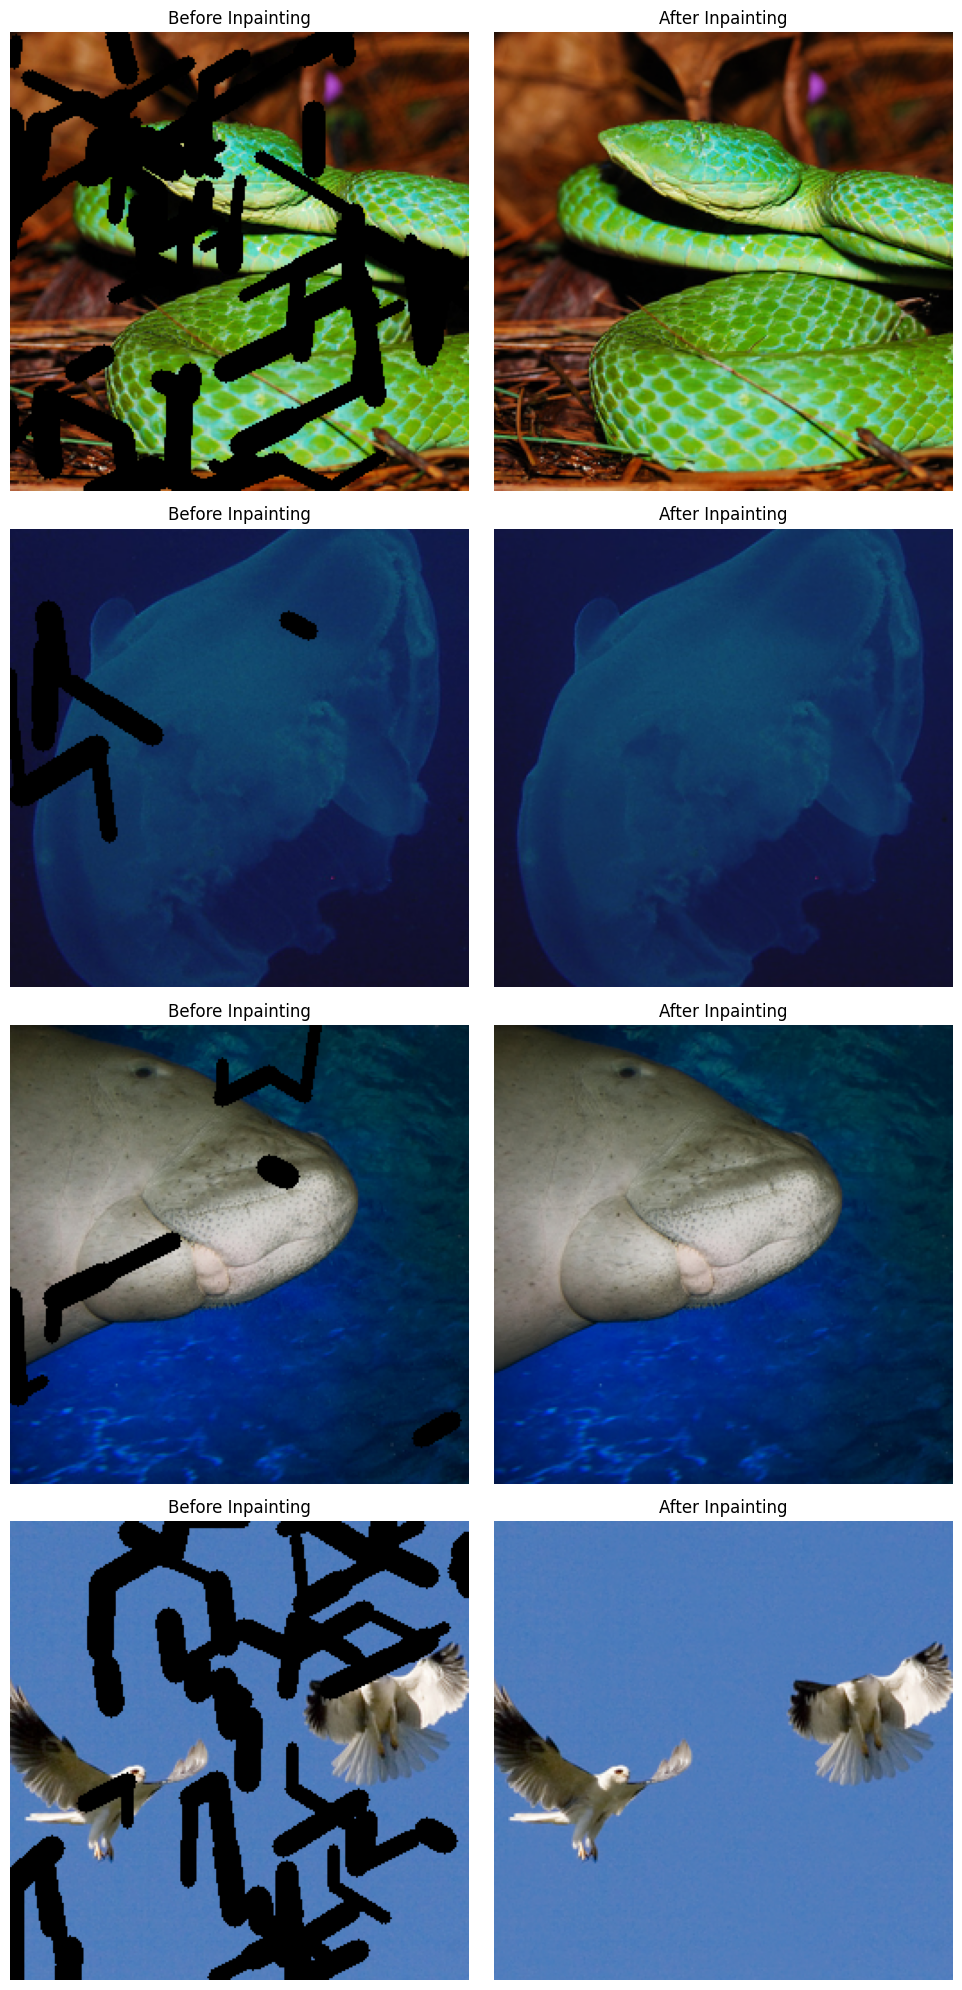

In [ ]:
import matplotlib.pyplot as plt
import glob
from PIL import Image

# Load images
masked_images = sorted(glob.glob("./log/test_inet256_thin/gt_masked/*.png"))
inpainted_images = sorted(glob.glob("./log/test_inet256_thin/inpainted/*.png"))

# Limit to first 4 images to avoid Colab truncation
num_images = min(4, len(masked_images), len(inpainted_images))

# Display images side by side
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

for i in range(num_images):
    img_masked = Image.open(masked_images[i])
    img_inpainted = Image.open(inpainted_images[i])

    axes[i, 0].imshow(img_masked)
    axes[i, 0].set_title("Before Inpainting")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(img_inpainted)
    axes[i, 1].set_title("After Inpainting")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
